# Dengue Data Generator using GANs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense


2025-04-29 13:08:25.657231: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 13:08:25.658009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 13:08:25.661846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 13:08:25.671108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745932105.686237 3302684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745932105.69

### Read Real Data

In [2]:
df = pd.read_csv('dengue-2013-2023.csv')
print(df.head())

  Disease  Year PROVINCE  Week_no  Count
0  Dengue  2013  Bangkok        1    351
1  Dengue  2013  Bangkok        2    399
2  Dengue  2013  Bangkok        3    300
3  Dengue  2013  Bangkok        4    280
4  Dengue  2013  Bangkok        5    262


### Preprocessing

In [3]:
# Only keep relevant columns
df = df[['Year', 'PROVINCE', 'Week_no', 'Count']]
df.head(5)

,Year,PROVINCE,Week_no,Count
0,2013,Bangkok,1,351
1,2013,Bangkok,2,399
2,2013,Bangkok,3,300
3,2013,Bangkok,4,280
4,2013,Bangkok,5,262


In [10]:
df_province = df.groupby('PROVINCE')['Count'].sum().sort_values(ascending=False).reset_index()
print(df_province.info())
print("\nTop 5 provinces with the most cases:")
print(df_province.head())
# Print the most affected province
most_affected_province = df_province.loc[df_province['Count'].idxmax()]
print(f"Most affected province: {most_affected_province['PROVINCE']} with {most_affected_province['Count']} cases.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PROVINCE  77 non-null     object
 1   Count     77 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB
None

Top 5 provinces with the most cases:
            PROVINCE   Count
0            Bangkok  109244
1         Chiang Mai   42376
2  Nakhon Ratchasima   41708
3         Chiang Rai   35968
4           Songkhla   30365
Most affected province: Bangkok with 109244 cases.


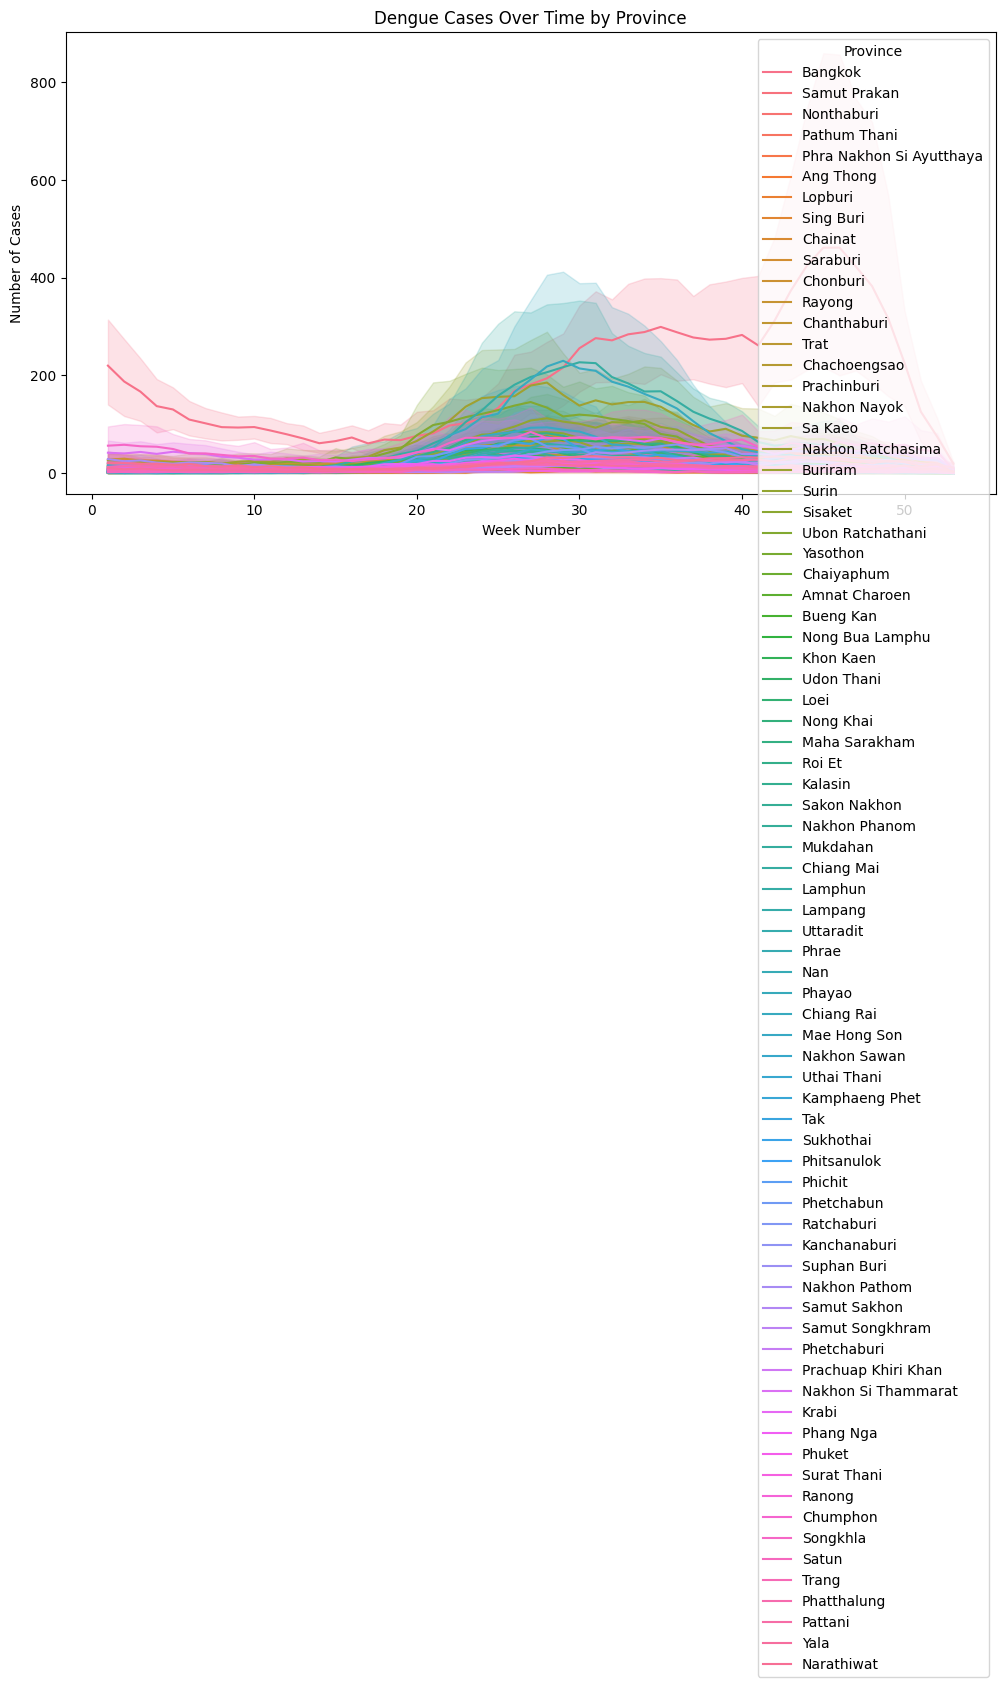

In [9]:
# Plot the time series of dengue cases
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Week_no', y='Count', hue='PROVINCE')
plt.title('Dengue Cases Over Time by Province')
plt.xlabel('Week Number')
plt.ylabel('Number of Cases')
plt.legend(title='Province')
plt.show()

In [11]:
# Apply Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['PROVINCE'] = le.fit_transform(df['PROVINCE'])
# Check the unique values after encoding
print(df['PROVINCE'].unique())
print(df.head())

[ 2 56 35 36 45  1 21 61  6 59 11 52  8 70  5 48 25 54 28  4 67 62 71 76
  7  0  3 33 16 72 20 34 23 53 13 55 27 24  9 19 18 74 46 31 40 10 22 29
 73 14 68 64 44 43 41 51 15 65 26 57 58 42 49 30 17 38 47 66 50 12 63 60
 69 39 37 75 32]
   Year  PROVINCE  Week_no  Count
0  2013         2        1    351
1  2013         2        2    399
2  2013         2        3    300
3  2013         2        4    280
4  2013         2        5    262


In [ ]:
# Write the encoded DataFrame to a new CSV file
# df.to_csv('thai_dengue_encoded.csv', index=False)

In [ ]:
# Transform data into MinMaxScaler
# df_np = df.to_numpy()
# scaler = MinMaxScaler()
# df_np = scaler.fit_transform(df_np)
# print(df_np[:5])

[[0.         0.02631579 0.         0.16204986]
 [0.         0.02631579 0.01923077 0.18421053]
 [0.         0.02631579 0.03846154 0.13850416]
 [0.         0.02631579 0.05769231 0.12927054]
 [0.         0.02631579 0.07692308 0.1209603 ]]


In [12]:
# Transform data number into range [0, 1]
# Only 'Count' is transformed because it represents the numerical values of dengue cases, 
# which need to be normalized for machine learning models. 
# 'Year', 'PROVINCE', and 'Week_no' are categorical or ordinal features, 
# and transforming them might not make sense in this context.
scaler = MinMaxScaler()
df['Count'] = scaler.fit_transform(df[['Count']])
# Check the transformed data
print(df.head())

   Year  PROVINCE  Week_no     Count
0  2013         2        1  0.162050
1  2013         2        2  0.184211
2  2013         2        3  0.138504
3  2013         2        4  0.129271
4  2013         2        5  0.120960


In [28]:
X_train, X_test, _, _ = train_test_split(df, df, test_size=0.2, random_state=42)
print(X_train[:5])

       Year  PROVINCE  Week_no     Count
30169  2020         9       12  0.001847
43186  2023        69        5  0.004617
17971  2017        55       24  0.010157
31621  2020        47        8  0.000462
18362  2017        46       44  0.000000


### Models

In [ ]:
# --- Hyperparameters
SEQ_LEN = 4
LATENT_DIM = 8

In [14]:
# --- Generator: noise → sequence
def build_generator(laten_dim, num_categories):
    """
    Build a generator model that takes a latent vector and generates a sequence.
    Args:
        laten_dim (int): Dimension of the latent space.
        num_categories: List containing the number of categories for each categorical/ordinal feature.
    Returns:
        model (tf.keras.Model): The generator model.
    """
    input_noise = Input(shape=(laten_dim,))

    # Shared dense layers
    x = Dense(64, activation='relu')(input_noise)
    x = Dense(128, activation='relu')(x)

    # Output for numerical features (Count)
    count_output = Dense(SEQ_LEN, activation='sigmoid', name='count_output')(x)
    
    # Output for categorical features (Year, Province, Week_no)
    categorial_outputs = []
    for i, num_cat in enumerate(num_categories):
        cat_output = Dense(num_cat, activation='softmax', name=f'cat_output_{i}')(x)
        categorial_outputs.append(cat_output)
    
    # Concatenate all outputs
    outputs = [count_output] + categorial_outputs

    generator = Model(inputs=input_noise, outputs=outputs)

    return generator

In [18]:
generator = build_generator(LATENT_DIM, [len(df['Year'].unique()), len(df['PROVINCE'].unique()), len(df['Week_no'].unique())])
# generator.compile(optimizer='adam', loss='mse')
generator.summary()

E0000 00:00:1745934520.506170 3302684 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745934520.507682 3302684 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        576 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ count_output        │ (None, 4)         │        516 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_output_0        │ (None, 11)        │      1,419 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_output_1        │ (None, 77)        │      9,933 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_output_2        │ (None, 53)        │      6,837 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,601 (107.82 KB)

 Trainable params: 27,601 (107.82 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def build_discriminator(input_dim, num_categories):
    """
    Build a discriminator model that takes a sequence and classifies it as real or fake.
    Args:
        input_dim (int): Dimension of the input sequence.
        num_categories: List containing the number of categories for each categorical/ordinal feature.
    Returns:
        model (tf.keras.Model): The discriminator model.
    """
    # Input for numerical feature (Count)
    count_input = Input(shape=(input_dim,), name='count_input')
    
    # Inputs for categorical/ordinal features
    categorical_inputs = []
    for i, num_cat in enumerate(num_categories):
        cat_input = Input(shape=(num_cat,), name=f'cat_input_{i}')
        categorical_inputs.append(cat_input)
    
    # Combine all inputs
    combined_inputs = [count_input] + categorical_inputs
    x = tf.keras.layers.Concatenate()(combined_inputs)
    
    # Shared dense layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    
    # Output for real/fake classification
    validity = Dense(1, activation='sigmoid', name='validity')(x)
    
    discriminator = Model(inputs=combined_inputs, outputs=validity, name='Discriminator')
    return discriminator

In [22]:
discriminator = build_discriminator(SEQ_LEN, [len(df['Year'].unique()), len(df['PROVINCE'].unique()), len(df['Week_no'].unique())])
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ count_input         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_0         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_1         │ (None, 77)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_2         │ (None, 53)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 145)       │          0 │ count_input[0][0… │
│ (Concatenate)       │                   │            │ cat_input_0[0][0… │
│                     │                   │            │ cat_input_1[0][0… │
│                     │                   │            │ cat_input_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     18,688 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validity (Dense)    │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,009 (105.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,009 (105.50 KB)

In [25]:
# GAN Model
noise_input = Input(shape=(LATENT_DIM,))
generator_output = generator(noise_input)
discriminator_output = discriminator(generator_output)
gan = Model(inputs=noise_input, outputs=discriminator_output)
gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 4),       │     27,601 │ input_layer_2[0]… │
│ (Functional)        │ (None, 11),       │            │                   │
│                     │ (None, 77),       │            │                   │
│                     │ (None, 53)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │     27,009 │ functional[1][0], │
│ (Functional)        │                   │            │ functional[1][1], │
│                     │                   │            │ functional[1][2], │
│                     │                   │            │ functional[1][3]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,610 (213.32 KB)

 Trainable params: 27,601 (107.82 KB)

 Non-trainable params: 27,009 (105.50 KB)

In [42]:
# --- Training
def train_gan(epochs, batch_size):
    """
    Train the GAN model.
    Args:
        epochs (int): Number of training epochs.
        batch_size (int): Size of each training batch.
    """
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        fake_data = generator.predict(noise)
        
        # Train Discriminator
        # Get a random batch of real sequences
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_sequences = X_train[idx]
        real_sequences = real_sequences.reshape(batch_size, SEQ_LEN)
        # Split real_sequences into separate inputs for the discriminator
        real_count = real_sequences[:, 3].reshape(-1, 1)  # Numerical feature (Count)
        real_year = tf.keras.utils.to_categorical(real_sequences[:, 0].astype(int) - df['Year'].min(), len(df['Year'].unique()))
        real_province = tf.keras.utils.to_categorical(real_sequences[:, 1].astype(int), len(df['PROVINCE'].unique()))
        real_week_no = tf.keras.utils.to_categorical(real_sequences[:, 2].astype(int) - 1, len(df['Week_no'].unique()))
        real_sequences = [real_count, real_year, real_province, real_week_no]
        
        d_loss_real = discriminator.train_on_batch(real_sequences, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        d_losses.append(d_loss[0])
        
        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        g_losses.append(g_loss[0])
        
        if epoch % 10 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss[0]:.4f}]")
    return d_losses, g_losses

In [45]:
BATCH_SIZE = 64
EPOCHS = 200

In [44]:
def train_gan2(generator, discriminator, epochs, batch_size):
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # Generate fake sequences
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        fake_sequences = generator.predict(noise)

        # Get a random batch of real sequences
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_sequences = X_train[idx]
        real_sequences = real_sequences.reshape(batch_size, SEQ_LEN)
        
        # Split real_sequences into separate inputs for the discriminator
        real_count = real_sequences[:, 3].reshape(-1, 1)  # Numerical feature (Count)
        real_year = tf.keras.utils.to_categorical(real_sequences[:, 0].astype(int) - df['Year'].min(), len(df['Year'].unique()))
        real_province = tf.keras.utils.to_categorical(real_sequences[:, 1].astype(int), len(df['PROVINCE'].unique()))
        real_week_no = tf.keras.utils.to_categorical(real_sequences[:, 2].astype(int) - 1, len(df['Week_no'].unique()))
        real_sequences = [real_count, real_year, real_province, real_week_no]

        # Create labels for real and fake sequences
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, real_labels)

        # Store losses for plotting
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Print the progress
        print(f"{epoch + 1}/{epochs} [D loss: {d_loss:.4f}, acc.: {100 * d_acc:.2f}%] [G loss: {g_loss:.4f}]")
    
    return d_losses, g_losses

In [46]:
# Trainin the network
d_losses, g_losses = train_gan2(generator, discriminator, EPOCHS, BATCH_SIZE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 145, but received input with shape (64, 142)[0m

Arguments received by Functional.call():
  • inputs=['tf.Tensor(shape=(64, 1), dtype=float64)', 'tf.Tensor(shape=(64, 11), dtype=float64)', 'tf.Tensor(shape=(64, 77), dtype=float64)', 'tf.Tensor(shape=(64, 53), dtype=float64)']
  • training=True
  • mask=['None', 'None', 'None', 'None']

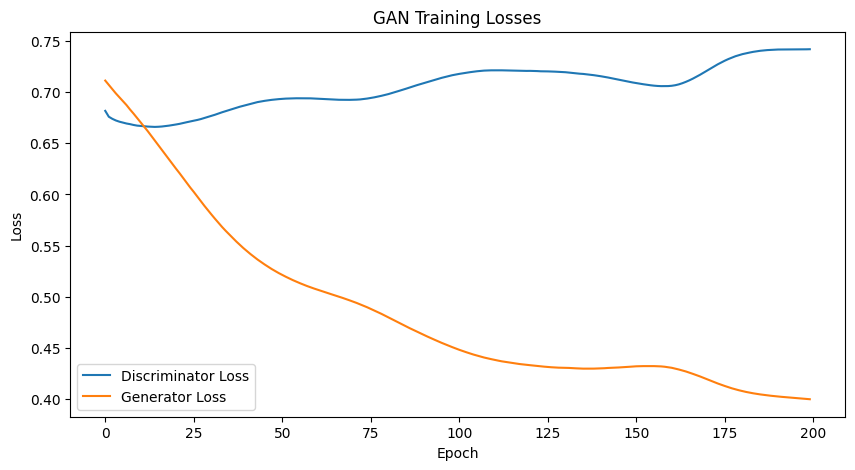

In [117]:
# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [118]:
# Generate new sequences
def generate_sequences(generator, num_sequences):
    noise = np.random.normal(0, 1, (num_sequences, LATENT_DIM))
    generated_sequences = generator.predict(noise)
    return generated_sequences

In [119]:
generated_sequences = generate_sequences(generator, 10)
print("Generated sequences:")
for seq in generated_sequences:
    # Inverse transform to get back to original scale
    seq = scaler.inverse_transform(seq.reshape(-1, 4))
    seq = seq.flatten()
    # Round to get integer values
    seq = np.round(seq).astype(int)

    # Reshape to original format
    seq = seq.reshape(1, 4)
    # Print the generated sequence
    print(seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Generated sequences:
[[2013    1   53    3]]
[[2013    0   53    3]]
[[2013    2   50    5]]
[[2013    7   45   21]]
[[2013    3   53    7]]
[[2013    4   52   16]]
[[2013    3   52   22]]
[[2013    2   53    9]]
[[2013    1   52    0]]
[[2013    5   12    2]]
